<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Natural Language Processing</h1>
<h1>Text Classification</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint

import string

import pandas as pd
import numpy as np
np.random.seed(123456)

import matplotlib
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchview
from torchview import draw_graph

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
stopwords = set(stopwords.words('english'))


import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 9c8c00758f3a2fa8e55e08f5aad405a157ca5dd2

matplotlib: 3.8.0
torch     : 2.3.0
watermark : 2.4.3
torchview : 0.2.6
re        : 2.2.1
nltk      : 3.8.1
numpy     : 1.26.4
pandas    : 2.2.3



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# IMDB Dataset

The IMDB dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). We load it directly from the data directory in the repository

In [4]:
data = pd.read_csv('data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In total, we have 50,000 reviews

In [5]:
data.shape

(50000, 2)

Extract the text of a couple of them. A positive one

In [6]:
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

And a negative one

In [7]:
data.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

We transform the sentiment label into a numeric value

In [8]:
data['label'] = data['sentiment'].progress_apply(lambda x: 1 if x=='positive' else 0)

  0%|          | 0/50000 [00:00<?, ?it/s]

Our classes are balanced

In [9]:
data[['sentiment', 'label']].groupby('sentiment').count()

,label
sentiment,
negative,25000
positive,25000


In [10]:
def keep_words(text):
    if len(set(text) & set(string.ascii_letters)) != len(set(text)):
        return None
    
    return text

def preprocess_pipeline(text):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(text)
    no_stopwords = [token for token in tokens if token not in stopwords]
    lemmas = [lemmatizer.lemmatize(t) for t in no_stopwords]
    words = [word for word in lemmas if keep_words(word) is not None]

    return ' '.join(words)

In [11]:
data['processed'] = data['review'].progress_apply(preprocess_pipeline)
data.head()

  0%|          | 0/50000 [00:00<?, ?it/s]

,review,sentiment,label,processed
0,One of the other reviewers has mentioned that ...,positive,1,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,A wonderful little production br br The filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,Petter Mattei Love Time Money visually stunnin...


In [12]:
data.processed[0]

'One reviewer mentioned watching Oz episode hooked They right exactly happened br br The first thing struck Oz brutality unflinching scene violence set right word GO Trust show faint hearted timid This show pull punch regard drug sex violence Its hardcore classic use br br It called OZ nickname given Oswald Maximum Security State Penitentary It focus mainly Emerald City experimental section prison cell glass front face inwards privacy high agenda Em City home many Aryans Muslims gangsta Latinos Christians Italians Irish scuffle death stare dodgy dealing shady agreement never far br br I would say main appeal show due fact go show would dare Forget pretty picture painted mainstream audience forget charm forget romance OZ mess around The first episode I ever saw struck nasty surreal I could say I ready I watched I developed taste Oz got accustomed high level graphic violence Not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turn

Save processed data for later use

In [13]:
data[['processed', 'label']].to_csv('data/imdb_processed.csv', index=False, header=True)

Extract all the tokens

In [14]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

Build vocabulary

In [15]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
word_dict = dict(zip(vocab, range(1, len(vocab)+1)))
word_dict['<PAD>'] = 0

word_list = ['<PAD>']
word_list.extend(vocab)

vocab_size = len(vocab)

Tokenize reviews

In [16]:
reviews_enc = [[word_dict[word] for word in review.split()] for review in tqdm(reviews)]

  0%|          | 0/50000 [00:00<?, ?it/s]

Make sure all the reviews have the same length. We truncate reviews that are too long and pad the ones that are too short

In [17]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

max_words = 500
features = pad_features(reviews_enc, pad_id=word_dict['<PAD>'], seq_length=max_words)

Now we have a matrix where each row corresponds to a unique review and each column to each of the words

In [18]:
features.shape

(50000, 500)

Train, test and valication splits

In [19]:
train_size = .7     # 70% used for training
val_size = .5       # 50% of test data set used for validation

In [20]:
labels = data.label.to_numpy()

# Training dataset
split_id = int(len(features) * train_size)
X_train, X_remain = features[:split_id], features[split_id:]
y_train, y_remain = labels[:split_id], labels[split_id:]

# Testing and Validation
split_val_id = int(len(X_remain) * val_size)
X_validation, X_test = X_remain[:split_val_id], X_remain[split_val_id:]
y_validation, y_test = y_remain[:split_val_id], y_remain[split_val_id:]

In [21]:
print('Shape of training data:', X_train.shape)
print('Shape of test data:', X_test.shape)
print('Shape of validation data:', X_validation.shape)

Shape of training data: (35000, 500)
Shape of test data: (7500, 500)
Shape of validation data: (7500, 500)


# PyTorch

## Tensor datasets

In [22]:
trainset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
validset = TensorDataset(torch.from_numpy(X_validation), torch.from_numpy(y_validation))
testset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

## Data Loaders

In [23]:
batch_size = 128
hidden_size = 32
output_size = 1

In [24]:
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

Finally, we are ready to define our models

# Feed Forward Model

We'll start by training a simple FF model without any fancyness. 

Our model will have an embedding layer to turn our numerical ids into vectors, a hidden dense layer of 32 neurons and ReLu activation followed by an output layer with just one neuron and a sigmoid activation

In [25]:
FF_model = nn.Sequential(
    nn.Embedding(vocab_size, 50),
    nn.Flatten(),
    nn.Linear(50*max_words, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Sigmoid()
)

In [26]:
print(FF_model)

Sequential(
  (0): Embedding(114608, 50)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=25000, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)


In [27]:
# define training device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


Hyperparameters

In [28]:
vocab_size = len(word_list)
output_size = 1
embedding_size = 50
hidden_size = 32

Then, we define some training config for our model. Since we have *binary classification* task, we will use **Binary Cross Entropy Loss (BCELoss)** as our loss function. And we will use **Adam** as optimizer as it shown in many references that it could find converge point quickly. Based on 

In [29]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(FF_model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
es_limit = 5

**This is our main part!**
<br>
So, here we define training and validation loop. We will use only 5 epochs and see if we need more or less epochs to obtain good performance. We log our loss and accuracy for each epochs, so we can plot them later to see how the performances. Inspired by https://github.com/LukeDitria/pytorch_tutorials

In [30]:
def train_model(model, epochs, optim):
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': epochs
    }

    # train loop
    model = model.to(device)

    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

        history['train_loss'].append(train_loss / len(trainloader))
        history['train_acc'].append(train_acc / len(trainloader))

        ####################
        # validation model #
        ####################

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
            epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
            epochloop.update()
            
    return history

In [31]:
def plot_history(history):    
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=True)
    
    epochs = range(history['epochs'])
    
    ax_lst[0].plot(epochs, history['train_loss'], label='Training')
    ax_lst[0].plot(epochs, history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)
    
    ax_lst[1].plot(epochs, history['train_acc'], label='Training')
    ax_lst[1].plot(epochs, history['val_acc'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)

    ax_lst[1].legend()
    
    fig.tight_layout()

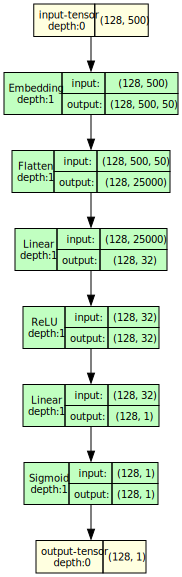

In [32]:
draw_graph(FF_model, input_data=torch.as_tensor(X_test[:128])).visual_graph

In [33]:
history = train_model(FF_model, epochs, optim)

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.902 Train Acc: 0.554 | Val Loss: 0.603 Val Acc: 0.664
Epoch 2/8 | Train Loss: 0.490 Train Acc: 0.763 | Val Loss: 0.553 Val Acc: 0.723
Epoch 3/8 | Train Loss: 0.323 Train Acc: 0.859 | Val Loss: 0.439 Val Acc: 0.809
Epoch 4/8 | Train Loss: 0.217 Train Acc: 0.914 | Val Loss: 0.529 Val Acc: 0.795
Epoch 5/8 | Train Loss: 0.148 Train Acc: 0.945 | Val Loss: 0.501 Val Acc: 0.815
Epoch 6/8 | Train Loss: 0.102 Train Acc: 0.964 | Val Loss: 0.549 Val Acc: 0.824
Epoch 7/8 | Train Loss: 0.070 Train Acc: 0.976 | Val Loss: 0.603 Val Acc: 0.825
Epoch 8/8 | Train Loss: 0.055 Train Acc: 0.981 | Val Loss: 0.673 Val Acc: 0.821


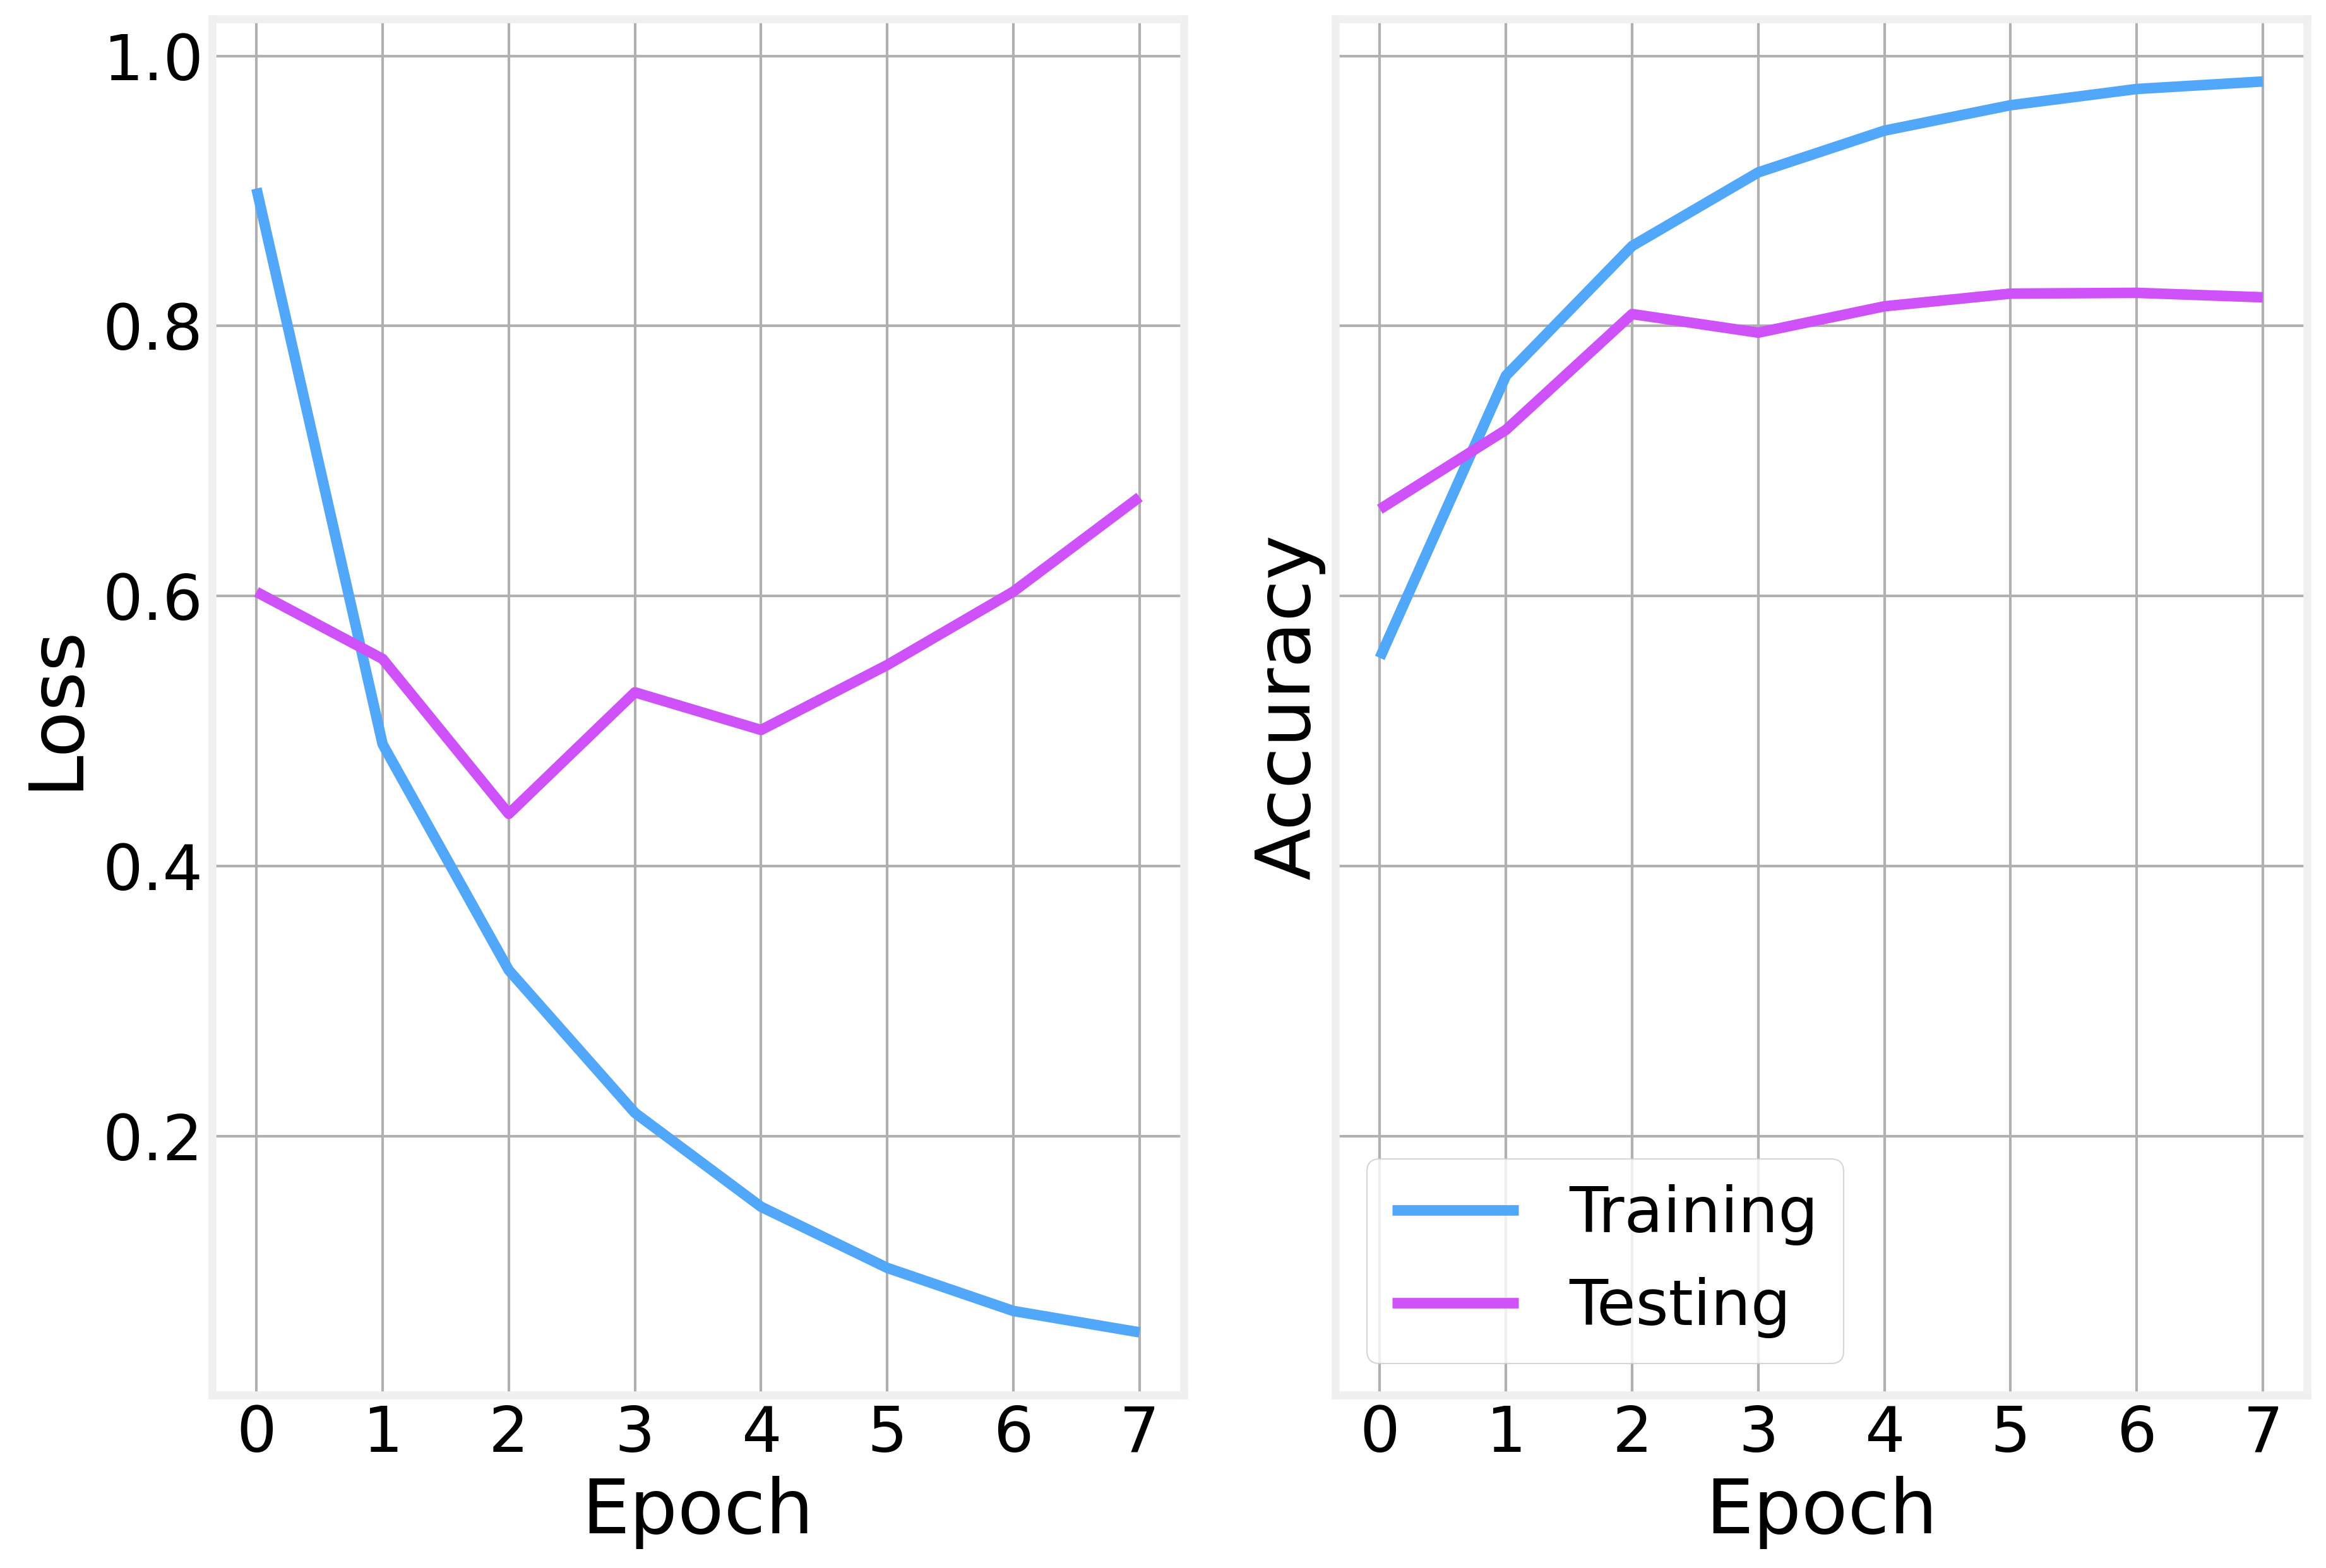

In [34]:
plot_history(history)

# Convolutional Model

Now we add a convolution layer between the embedding layer and the dense layer

In [35]:
Conv_model = nn.Sequential(
    nn.Embedding(vocab_size, 50),
    nn.Conv1d(max_words, max_words, kernel_size=3, padding='same'),
    nn.MaxPool1d(2),
    nn.Flatten(),
    nn.Linear(25*max_words, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Sigmoid()
)

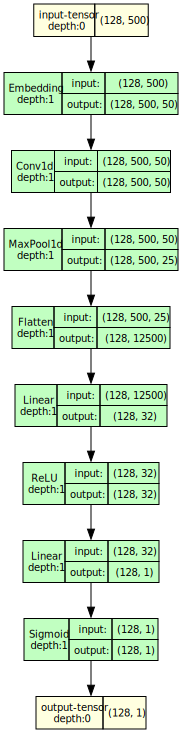

In [36]:
draw_graph(Conv_model, input_data=torch.as_tensor(X_test[:128])).visual_graph

In [37]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(Conv_model.parameters(), lr=lr)
grad_clip = 5
epochs = 16
print_every = 1
es_limit = 5

In [38]:
conv_history = train_model(Conv_model, epochs, optim)

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/16 | Train Loss: 0.654 Train Acc: 0.610 | Val Loss: 0.496 Val Acc: 0.766
Epoch 2/16 | Train Loss: 0.397 Train Acc: 0.821 | Val Loss: 0.419 Val Acc: 0.816
Epoch 3/16 | Train Loss: 0.266 Train Acc: 0.891 | Val Loss: 0.392 Val Acc: 0.833
Epoch 4/16 | Train Loss: 0.185 Train Acc: 0.929 | Val Loss: 0.431 Val Acc: 0.838
Epoch 5/16 | Train Loss: 0.119 Train Acc: 0.958 | Val Loss: 0.498 Val Acc: 0.838
Epoch 6/16 | Train Loss: 0.076 Train Acc: 0.975 | Val Loss: 0.582 Val Acc: 0.837
Epoch 7/16 | Train Loss: 0.047 Train Acc: 0.986 | Val Loss: 0.688 Val Acc: 0.841
Epoch 8/16 | Train Loss: 0.030 Train Acc: 0.992 | Val Loss: 0.822 Val Acc: 0.838
Epoch 9/16 | Train Loss: 0.019 Train Acc: 0.995 | Val Loss: 1.103 Val Acc: 0.834
Epoch 10/16 | Train Loss: 0.015 Train Acc: 0.996 | Val Loss: 1.367 Val Acc: 0.833
Epoch 11/16 | Train Loss: 0.019 Train Acc: 0.994 | Val Loss: 1.651 Val Acc: 0.836
Epoch 12/16 | Train Loss: 0.023 Train Acc: 0.991 | Val Loss: 1.842 Val Acc: 0.830
Epoch 13/16 | Train Loss:

Compile and fit the model

This model takes significantly longer to train, but produces much better results

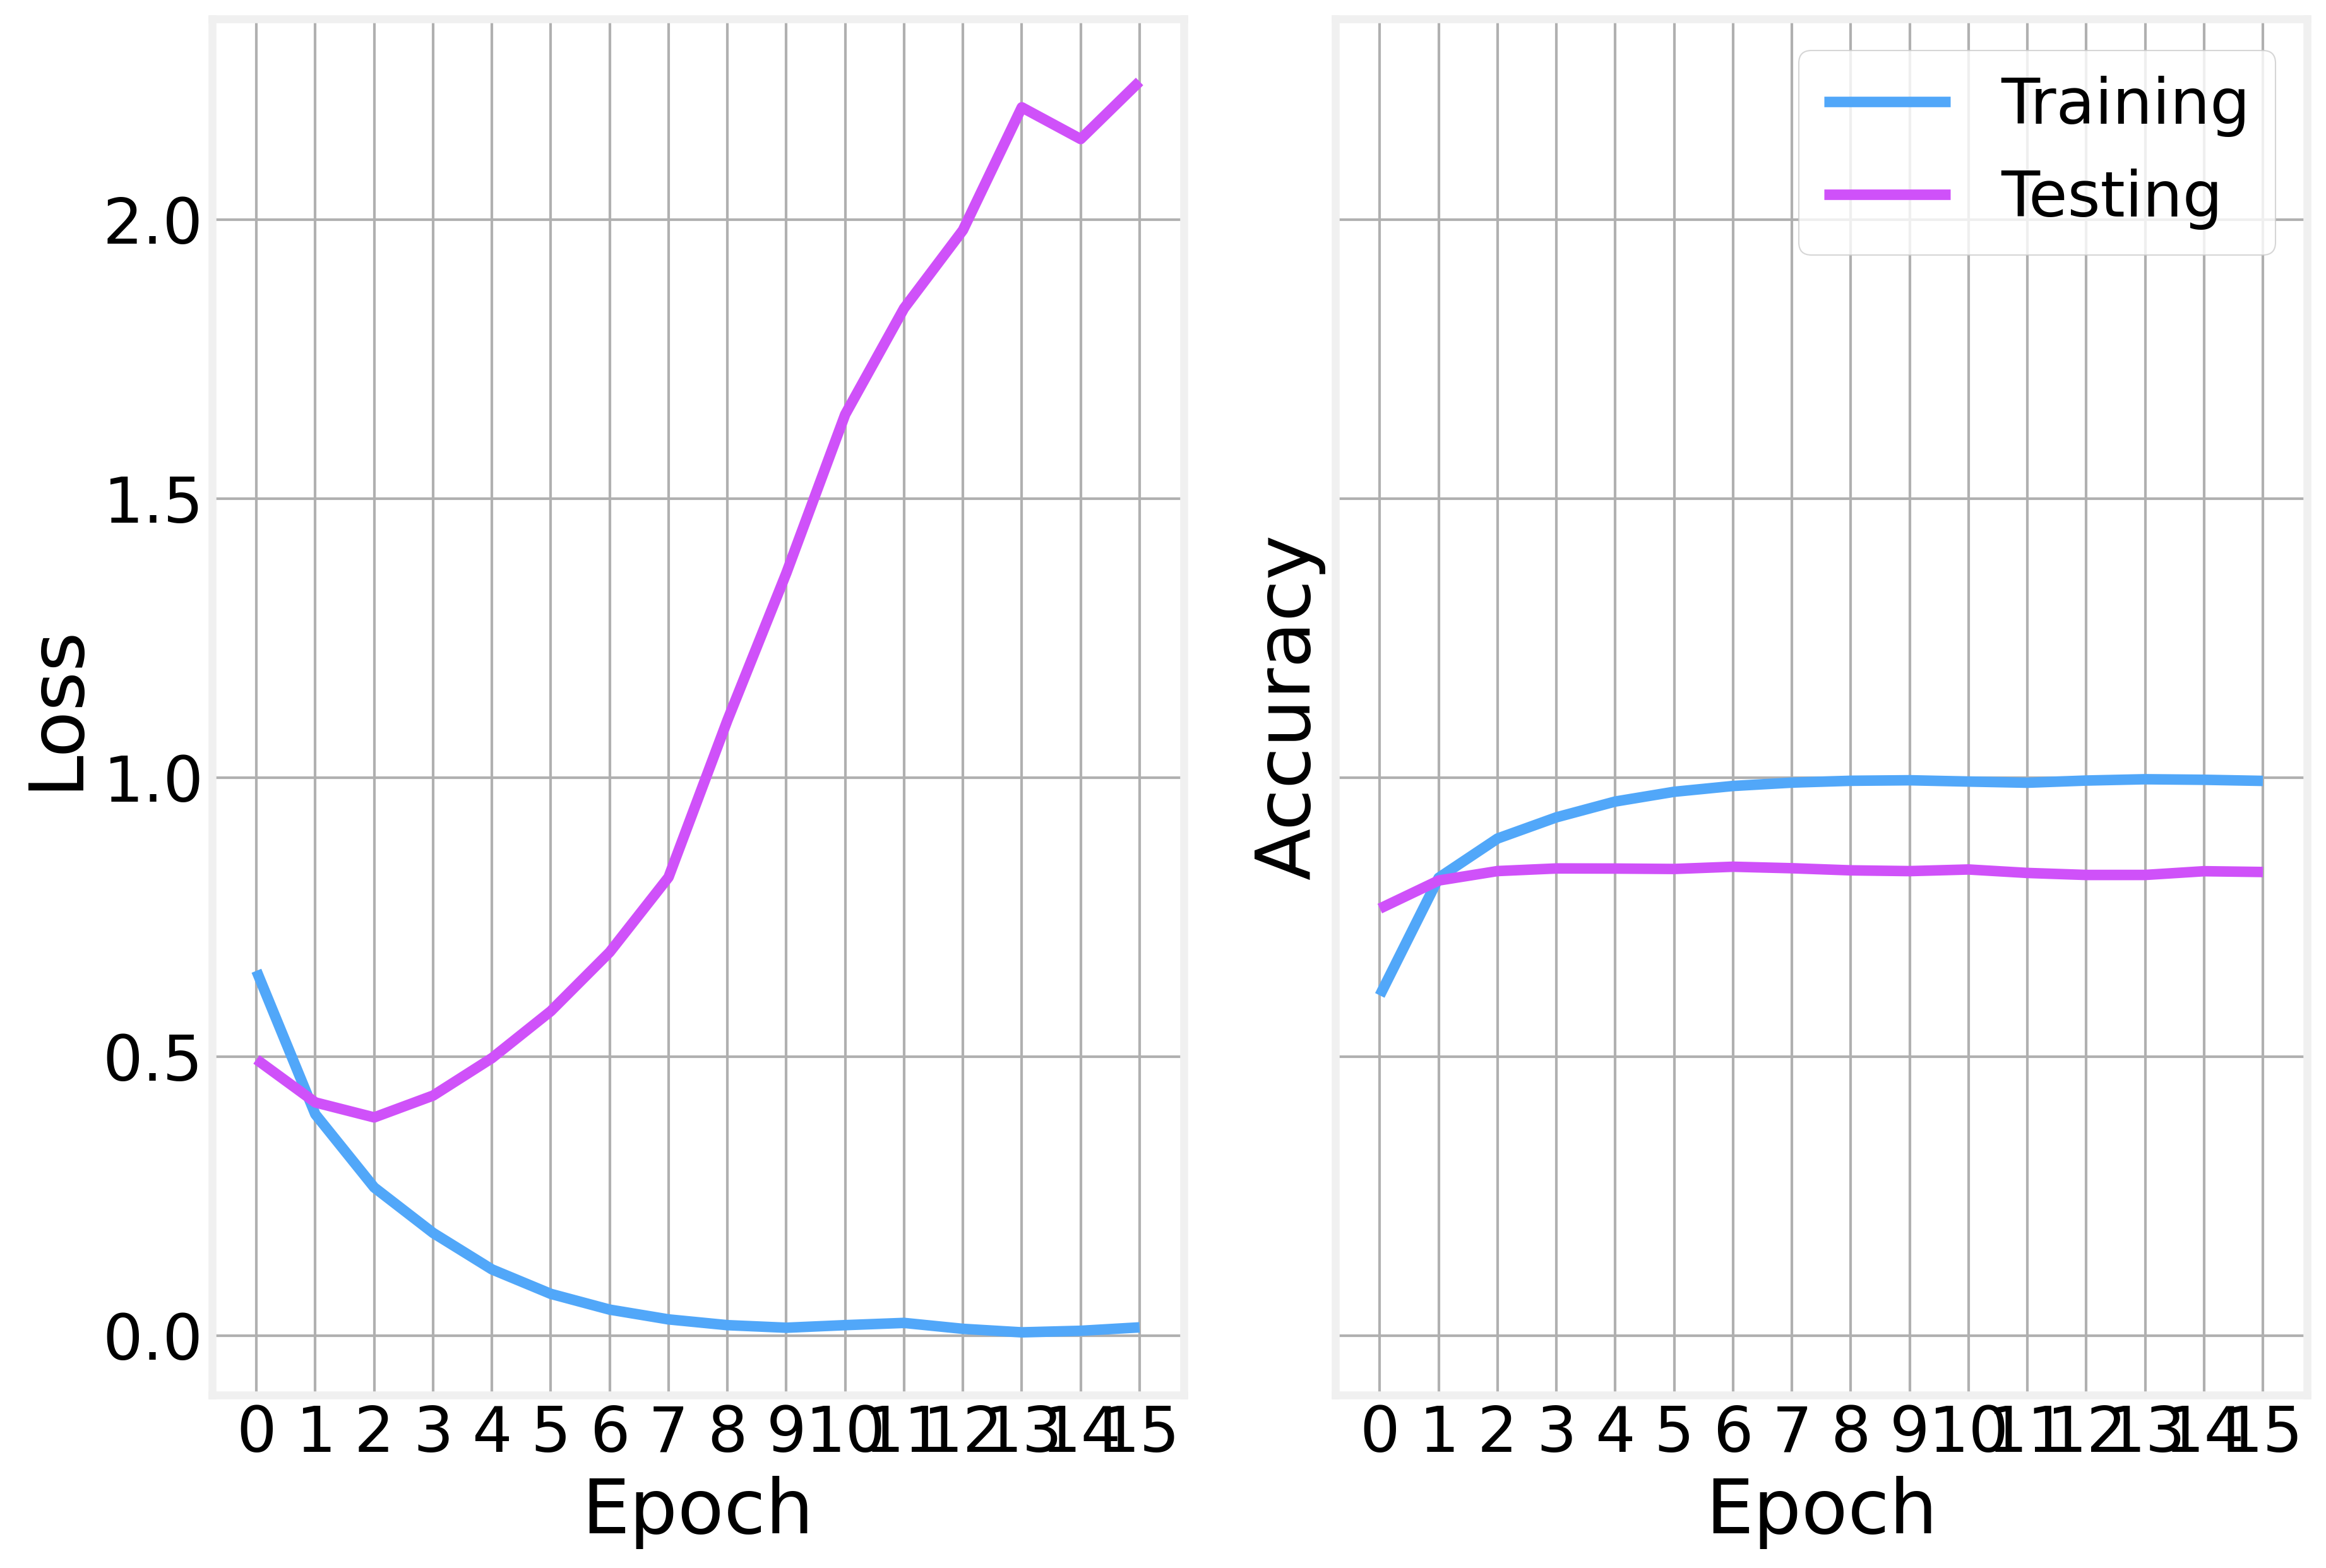

In [39]:
plot_history(conv_history)

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>